In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from PIL import Image

In [2]:
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf

In [4]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose

Using TensorFlow backend.


In [5]:
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [6]:
p=os.getcwd()

In [7]:
print(p)

/home/ipsa


In [8]:
im_width = 128
im_height = 128
border = 5

In [9]:
path_train = '/home/ipsa/ph2/'
path_test = '/home/ipsa/Downloads/TMAP/test/'

In [10]:
def get_data(path, train=True):
    ids = next(os.walk(path + "images"))[2]
    print(ids)
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + 'images/' + id_, grayscale=True)
        x_img = img_to_array(img)
        #plt.imshow(x_img/255.)
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
        #plt.imshow(x_img/255.)
        # Load masks
        if train:
            mask = img_to_array(load_img(path + 'masks/' + id_, grayscale=True))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X

In [11]:
X, y = get_data(path_train, train=True)

['IMD079.jpg', 'IMD121.jpg', 'IMD027.jpg', 'IMD047.jpg', 'IMD155.jpg', 'IMD113.jpg', 'IMD075.jpg', 'IMD084.jpg', 'IMD085.jpg', 'IMD122.jpg', 'IMD173.jpg', 'IMD005.jpg', 'IMD000.jpg', 'IMD198.jpg', 'IMD124.jpg', 'IMD170.jpg', 'IMD189.jpg', 'IMD074.jpg', 'IMD144.jpg', 'IMD068.jpg', 'IMD129.jpg', 'IMD020.jpg', 'IMD044.jpg', 'IMD043.jpg', 'IMD149.jpg', 'IMD125.jpg', 'IMD007.jpg', 'IMD073.jpg', 'IMD014.jpg', 'IMD169.jpg', 'IMD110.jpg', 'IMD024.jpg', 'IMD111.jpg', 'IMD162.jpg', 'IMD088.jpg', 'IMD147.jpg', 'IMD082.jpg', 'IMD010.jpg', 'IMD154.jpg', 'IMD156.jpg', 'IMD114.jpg', 'IMD039.jpg', 'IMD090.jpg', 'IMD098.jpg', 'IMD199.jpg', 'IMD065.jpg', 'IMD097.jpg', 'IMD099.jpg', 'IMD146.jpg', 'IMD130.jpg', 'IMD059.jpg', 'IMD041.jpg', 'IMD119.jpg', 'IMD076.jpg', 'IMD134.jpg', 'IMD120.jpg', 'IMD186.jpg', 'IMD036.jpg', 'IMD159.jpg', 'IMD056.jpg', 'IMD157.jpg', 'IMD081.jpg', 'IMD103.jpg', 'IMD101.jpg', 'IMD163.jpg', 'IMD019.jpg', 'IMD172.jpg', 'IMD116.jpg', 'IMD158.jpg', 'IMD128.jpg', 'IMD176.jpg', 'IMD0

/home/ipsa/m1/lib/python3.5/site-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/ipsa/m1/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


In [12]:
X[0].shape

(128, 128, 1)

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=2668)

In [20]:
ix = random.randint(0, len(X_train))

In [21]:
has_mask = y_train[ix].max() > 0

In [22]:
print(y_train.shape)

(140, 128, 128, 1)


In [23]:
print(ax)

NameError: name 'ax' is not defined

In [24]:
print(ix)

20


In [25]:
ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('burn');

NameError: name 'ax' is not defined

In [26]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [27]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [28]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=19, dropout=0.5, batchnorm=True)


In [29]:
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 10) 100         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 10) 40          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 10) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [28]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.1, verbose=1),
    ModelCheckpoint('model-weights-ph.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [29]:
results = model.fit(X_train, y_train, batch_size=9, epochs=10, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 140 samples, validate on 60 samples
Epoch 1/10
140/140 [==============================] - 17s 122ms/step - loss: 0.6333 - acc: 0.7172 - val_loss: 0.5064 - val_acc: 0.8180

Epoch 00001: val_loss improved from inf to 0.50638, saving model to model-weights-ph.h5
Epoch 2/10
140/140 [==============================] - 5s 39ms/step - loss: 0.4751 - acc: 0.8381 - val_loss: 0.3143 - val_acc: 0.8700

Epoch 00002: val_loss improved from 0.50638 to 0.31433, saving model to model-weights-ph.h5
Epoch 3/10
140/140 [==============================] - 6s 39ms/step - loss: 0.3974 - acc: 0.8788 - val_loss: 0.3708 - val_acc: 0.8249

Epoch 00003: val_loss did not improve from 0.31433
Epoch 4/10
140/140 [==============================] - 6s 39ms/step - loss: 0.3738 - acc: 0.8773 - val_loss: 0.4200 - val_acc: 0.8160

Epoch 00004: val_loss did not improve from 0.31433
Epoch 5/10
140/140 [==============================] - 5s 39ms/step - loss: 0.3416 - acc: 0.8925 - val_loss: 0.2998 - val_acc: 0.8739

E

NameError: name 'results' is not defined

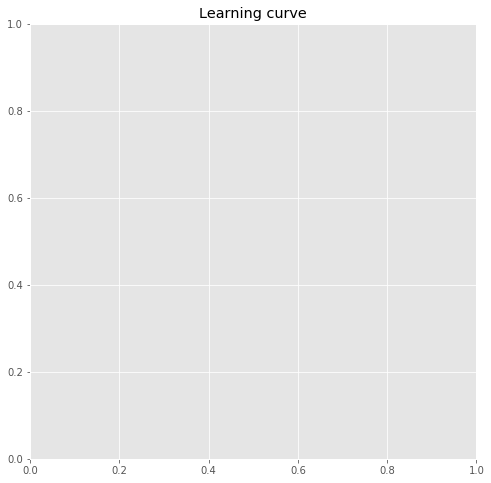

In [31]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [32]:
model.load_weights('model-weights-ph.h5')

In [33]:
model.evaluate(X_valid, y_valid, verbose=1)

60/60 [==============================] - 8s 129ms/step


[0.2146168440580368, 0.9071482340494792]

In [34]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

60/60 [==============================] - 0s 8ms/step


In [35]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)

In [36]:
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [37]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='coolwarm')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('patient image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('ground truth')

    ax[2].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('burn predicted binary');
    
    ax[3].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('burn predicted')
    
    

In [41]:
type(preds_val)

numpy.ndarray

In [70]:
y=preds_val_t
len(y)
print(y.shape)
np.sum(y)

(60, 128, 128, 1)


339275

In [71]:
x=[]
for n in range(0,60):
    x.append(n)

In [72]:
yy=[]
for n in range(0,60):
    yy.append(np.sum(y[n]))

(0.0, 1.0, 0.0, 1.0)

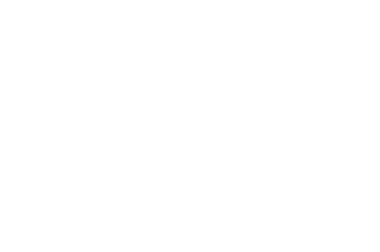

In [75]:
plt.axis('off')

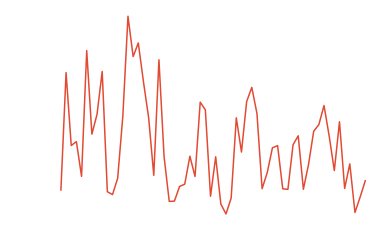

In [76]:
plt.axis('off')
plt.plot(x,yy)

In [58]:
y[43][23][23]
np.sum(y[46])

3888.2805

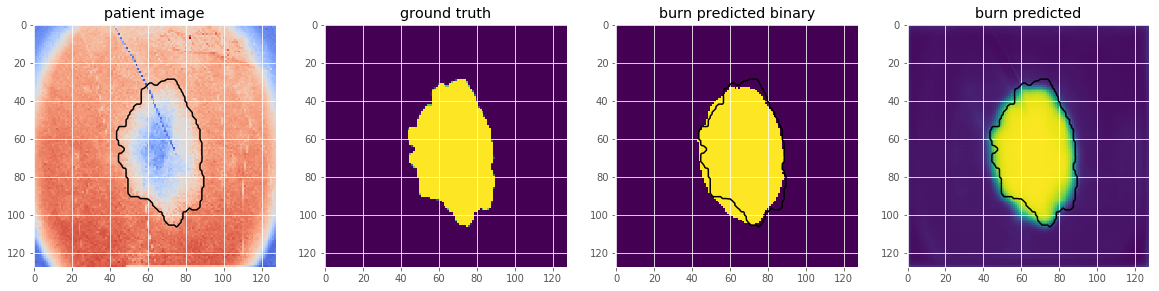

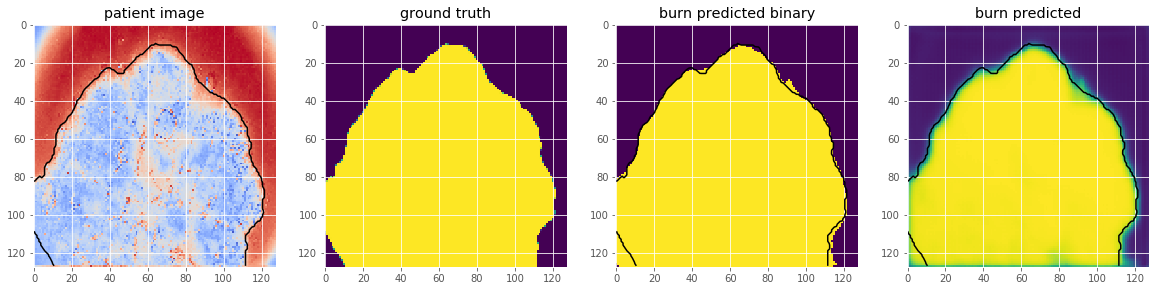

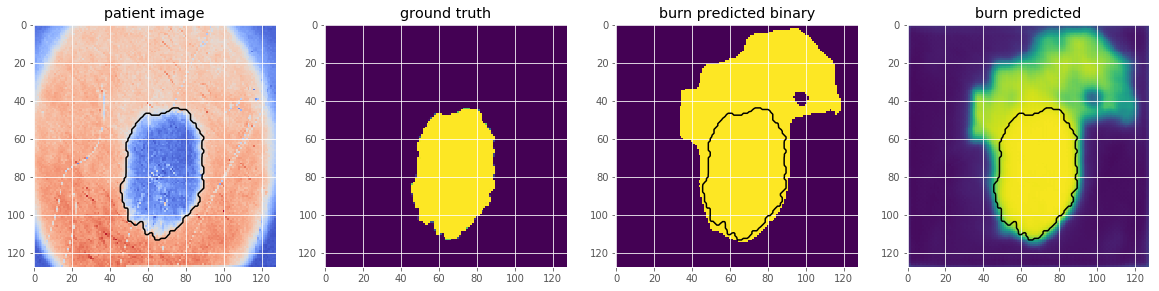

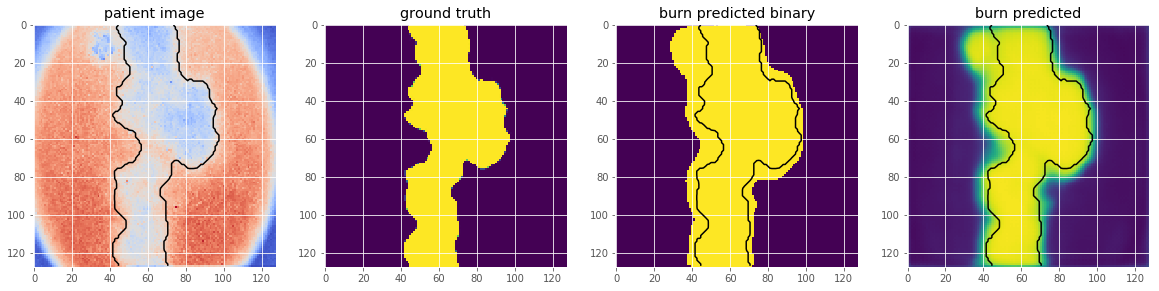

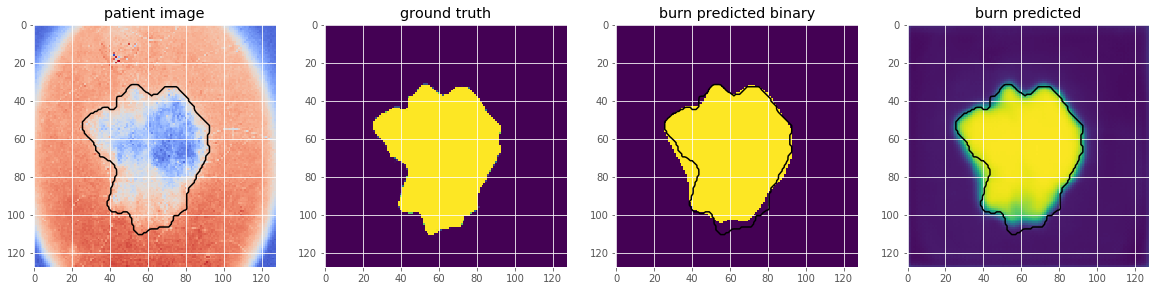

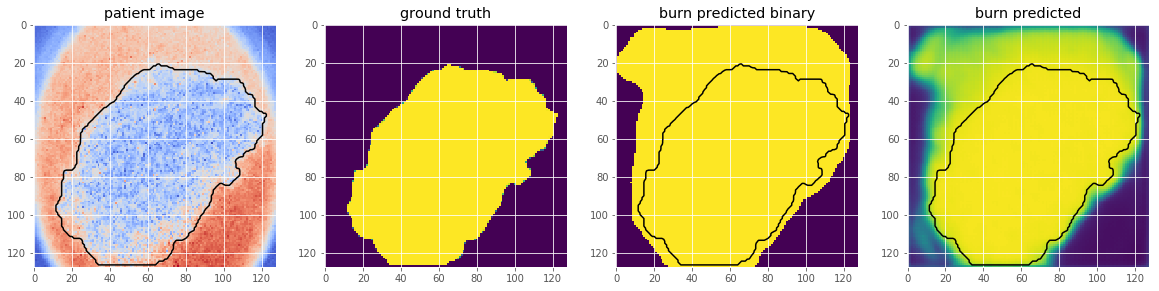

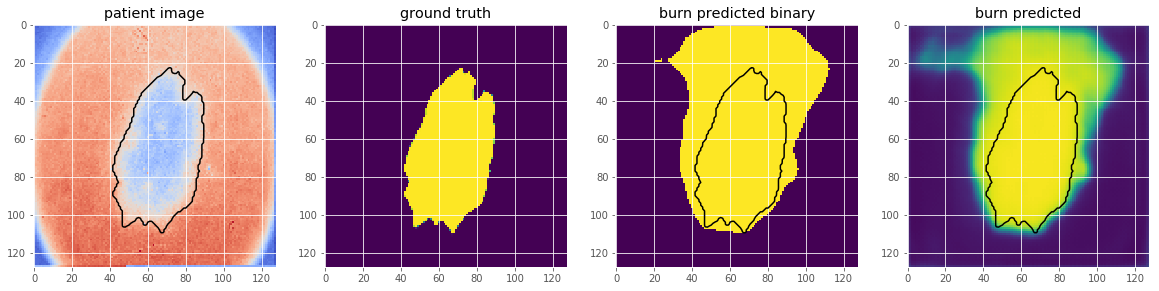

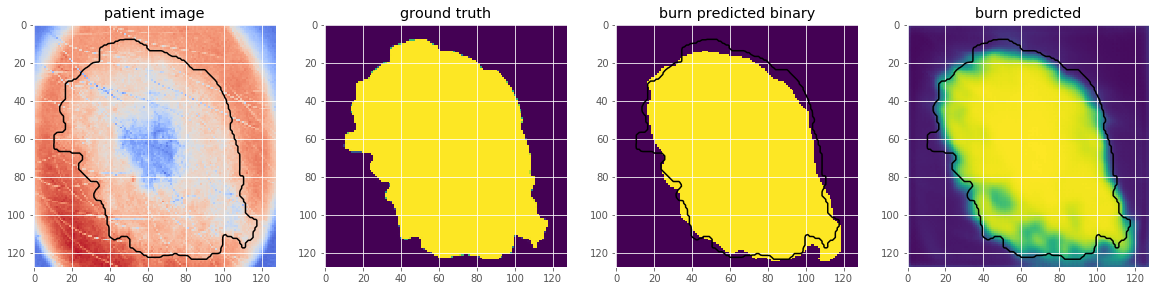

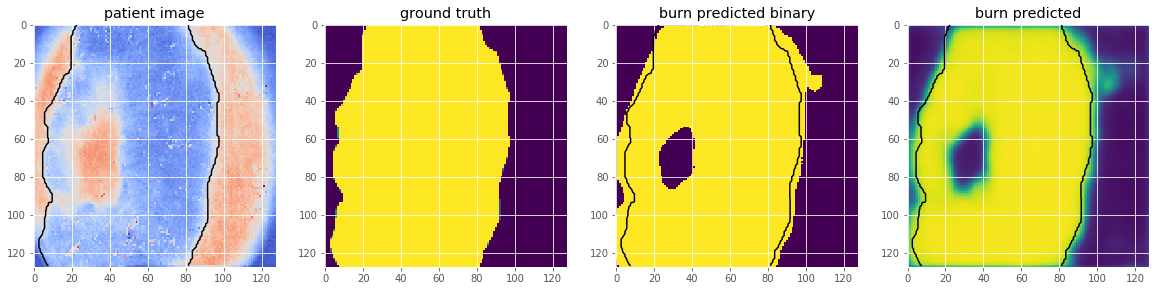

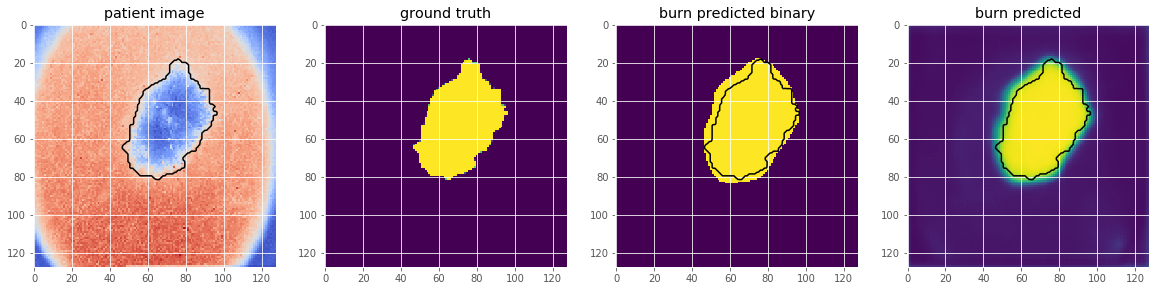

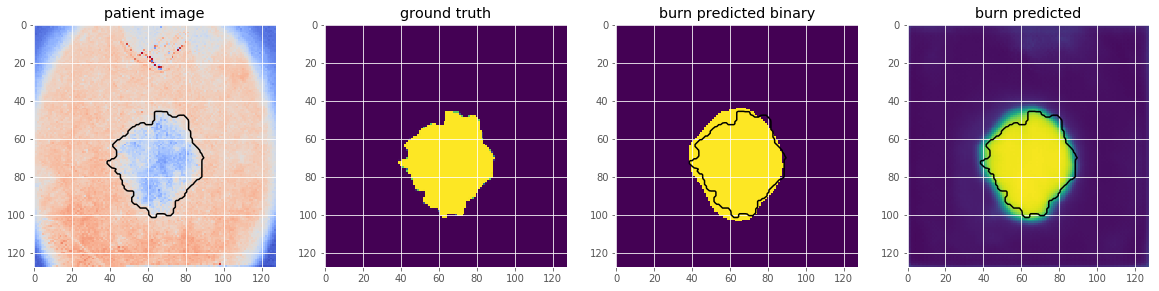

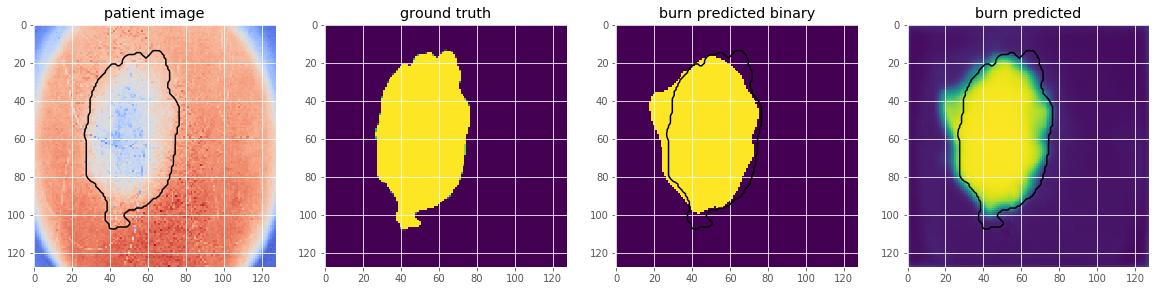

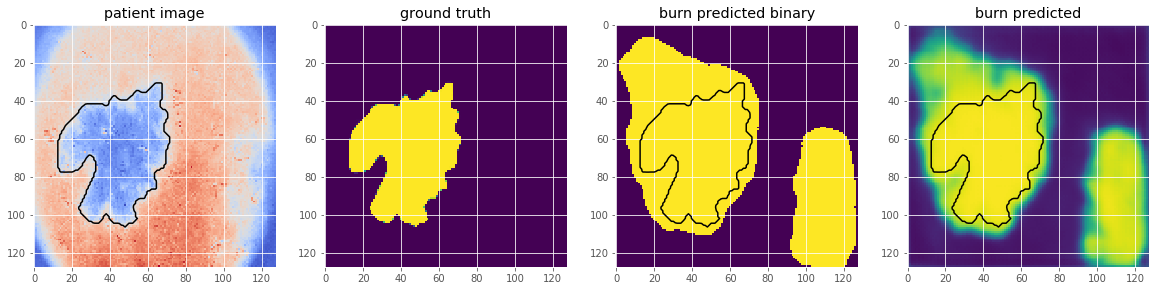

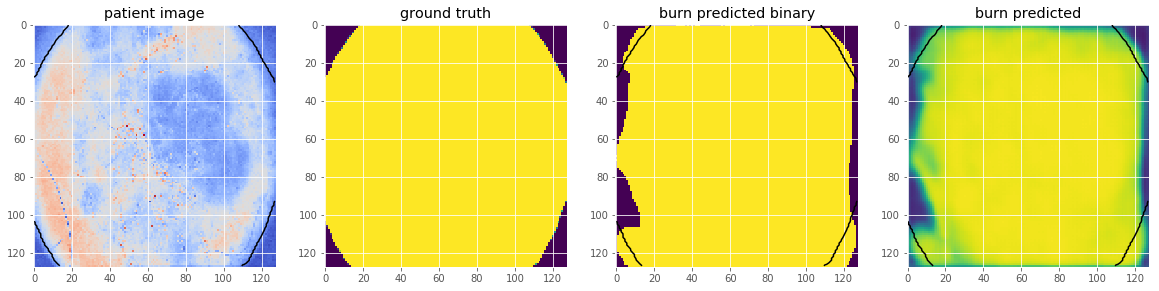

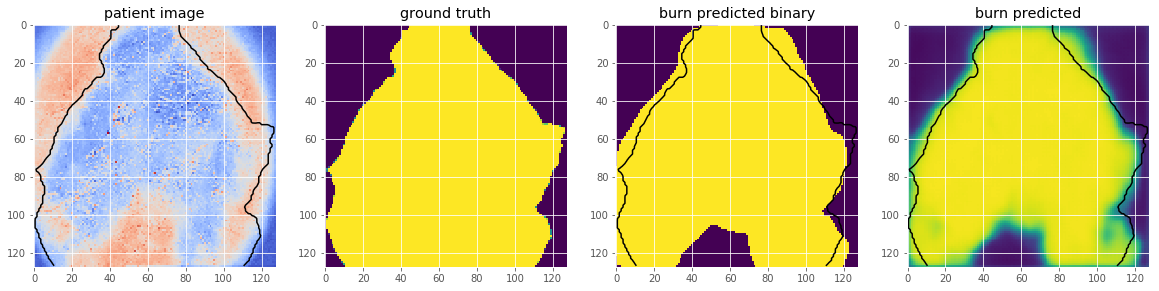

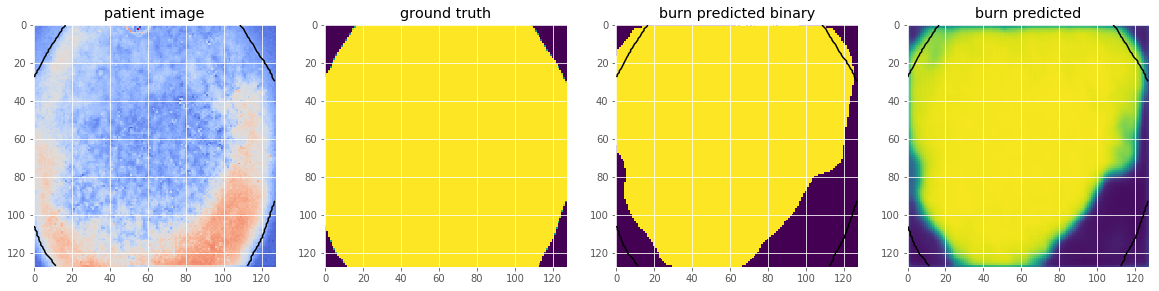

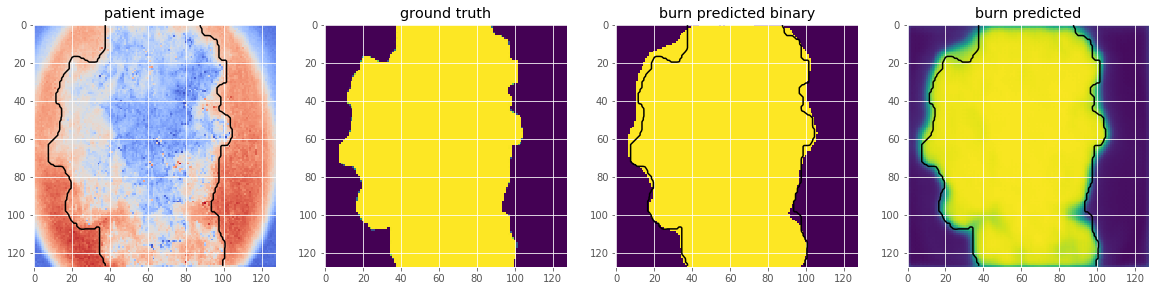

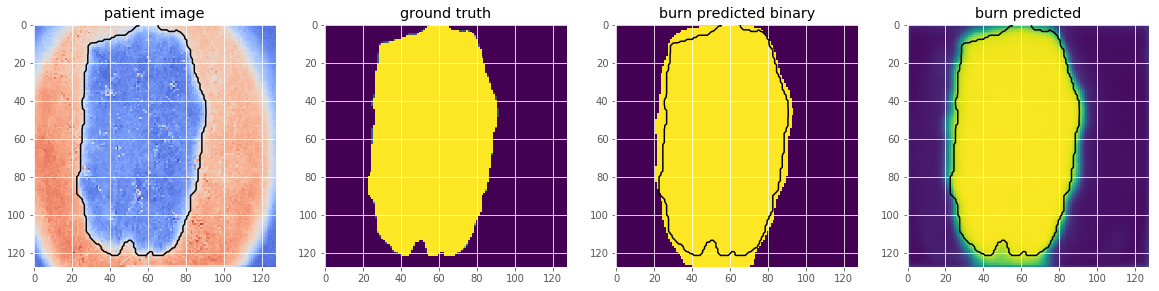

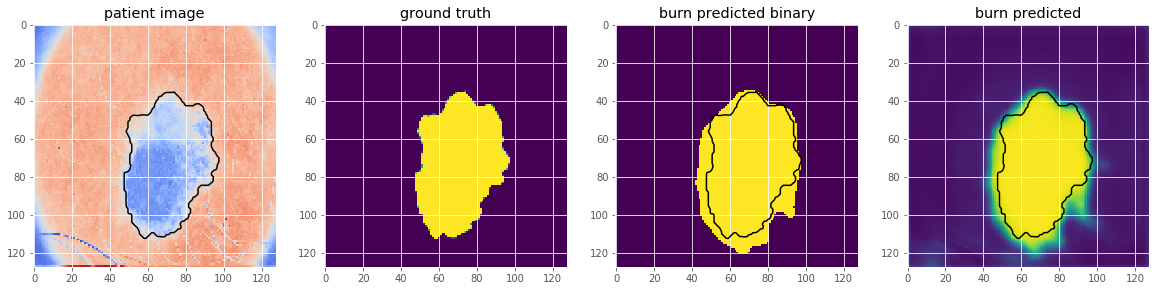

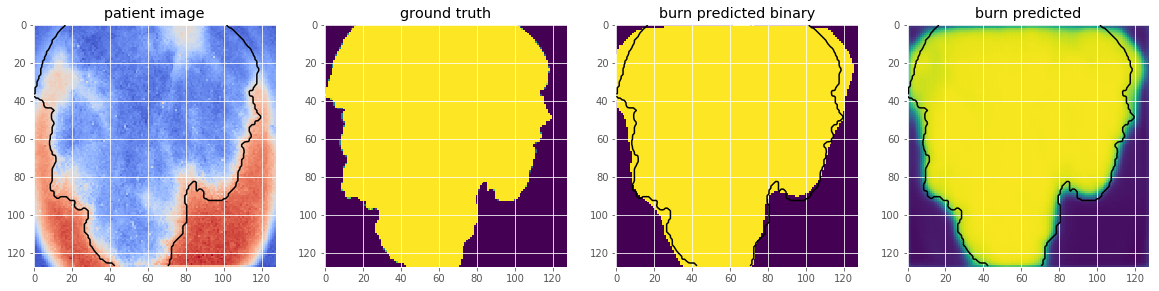

In [89]:
for u in range(0,20):
    plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=u)

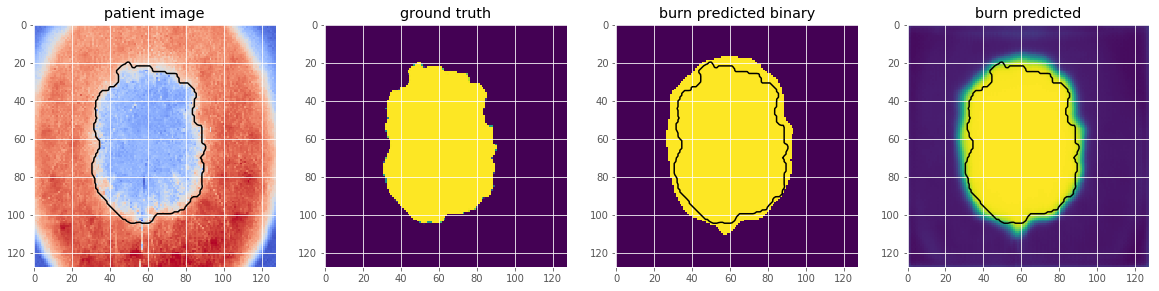

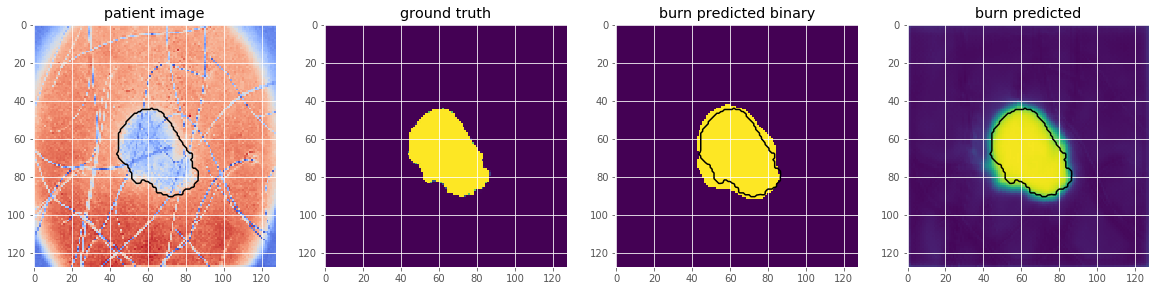

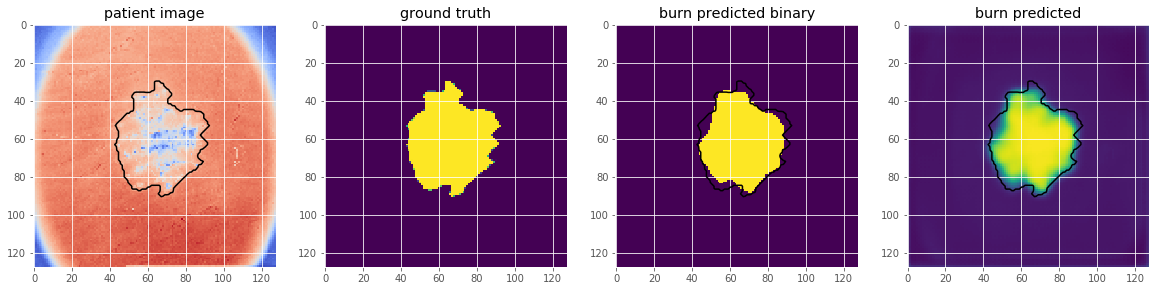

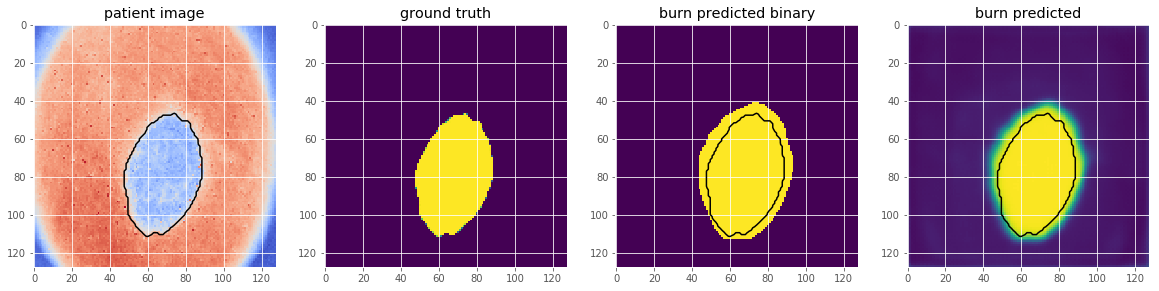

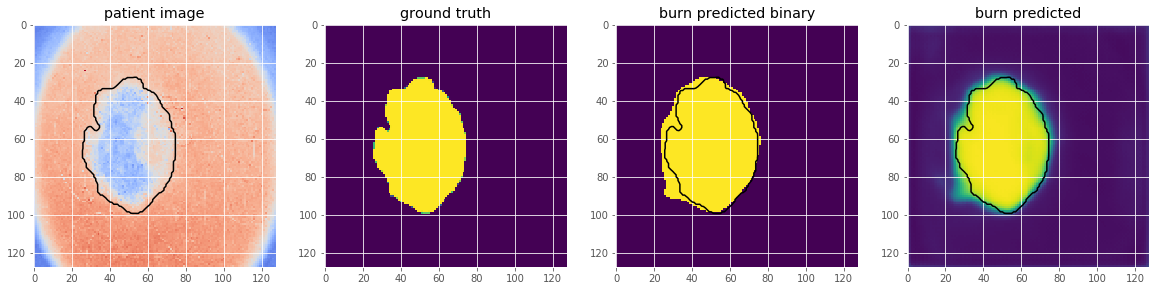

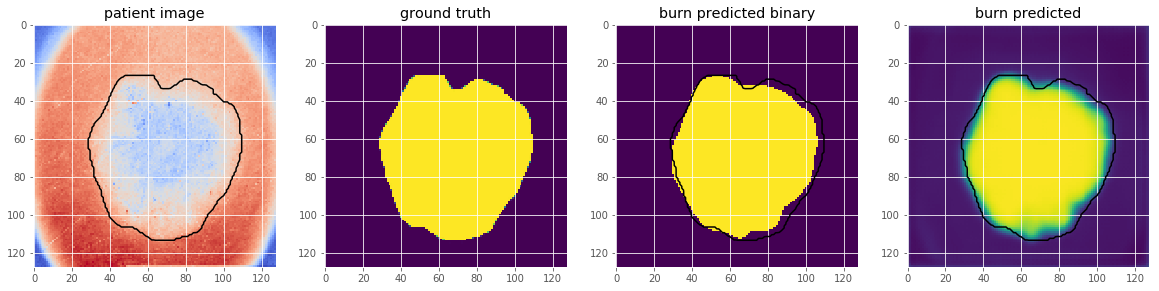

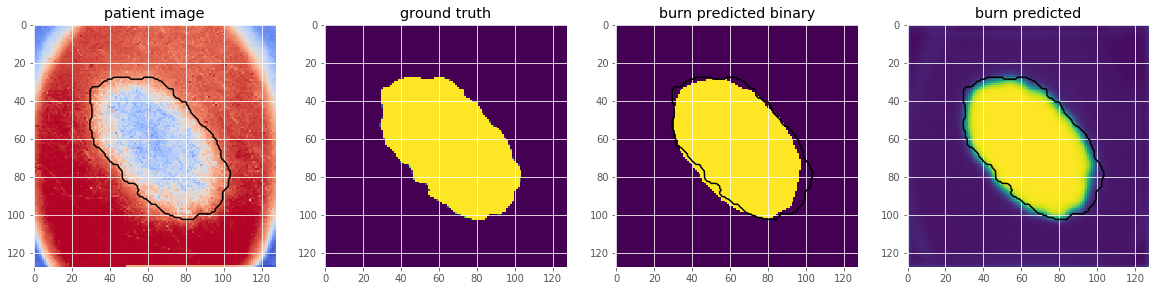

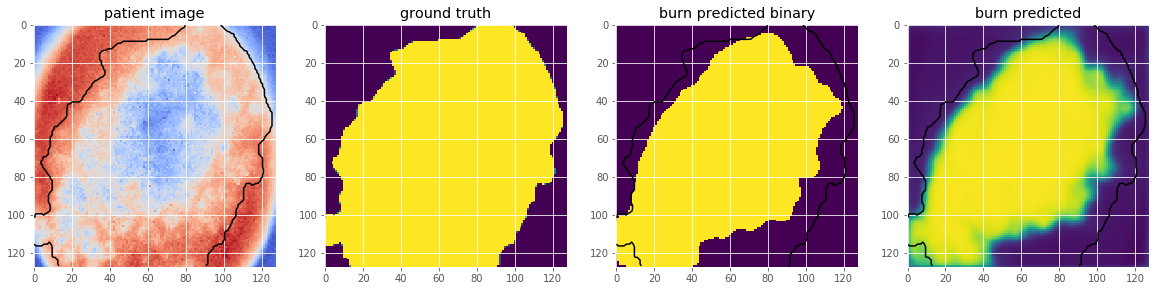

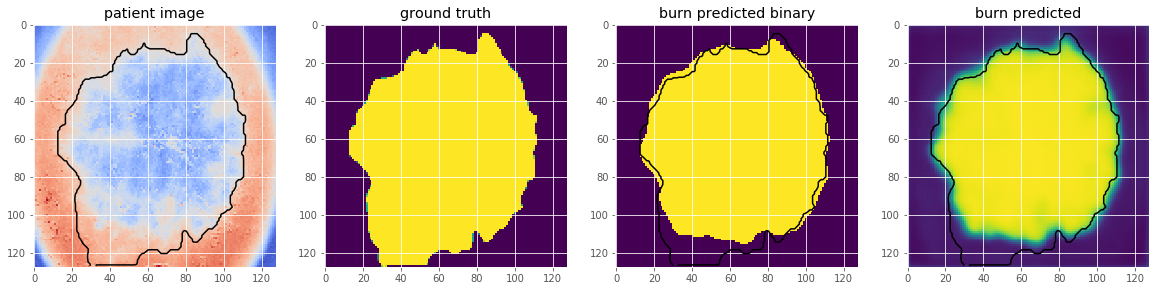

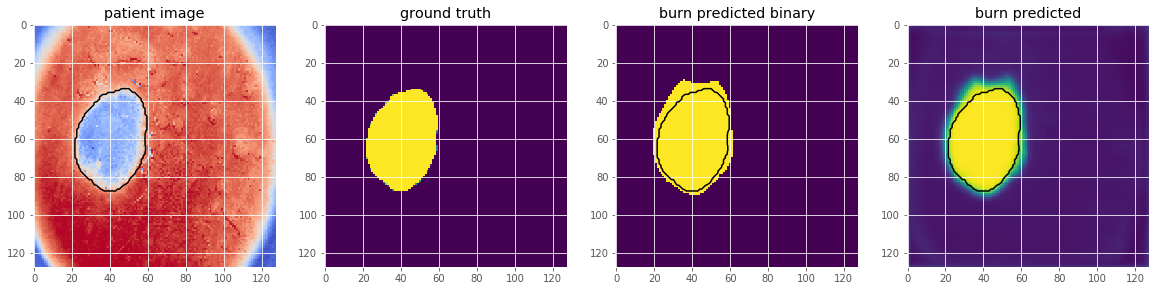

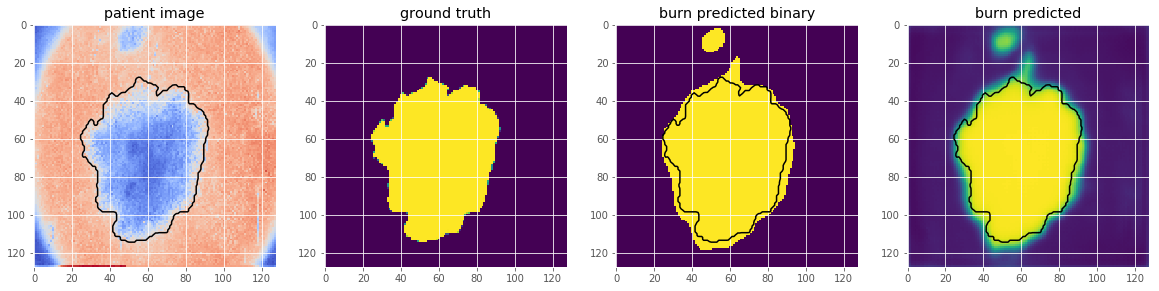

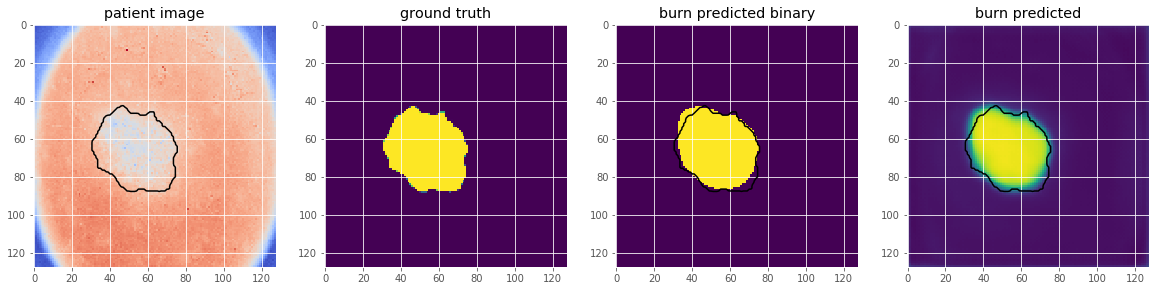

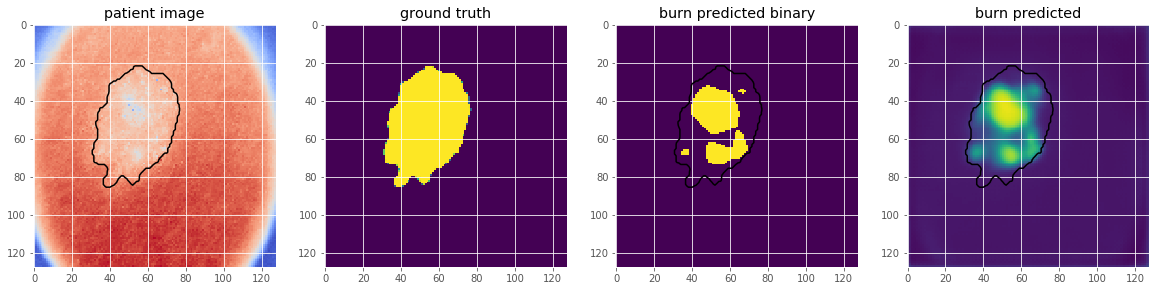

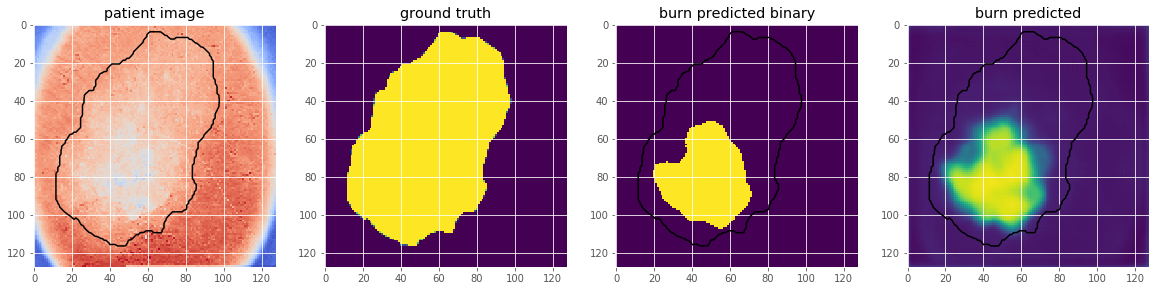

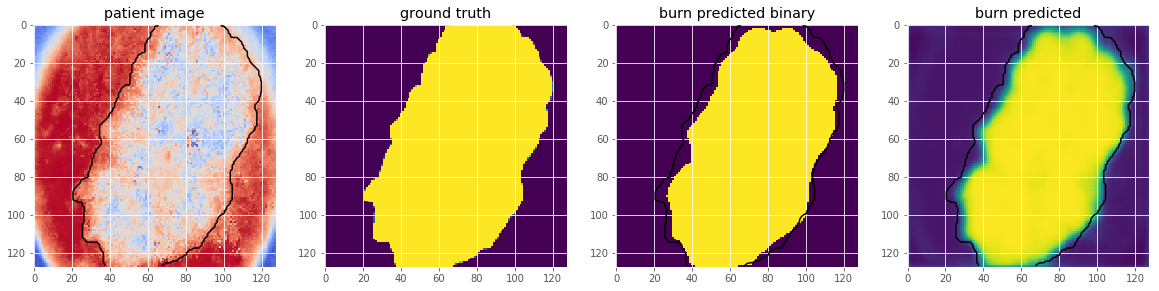

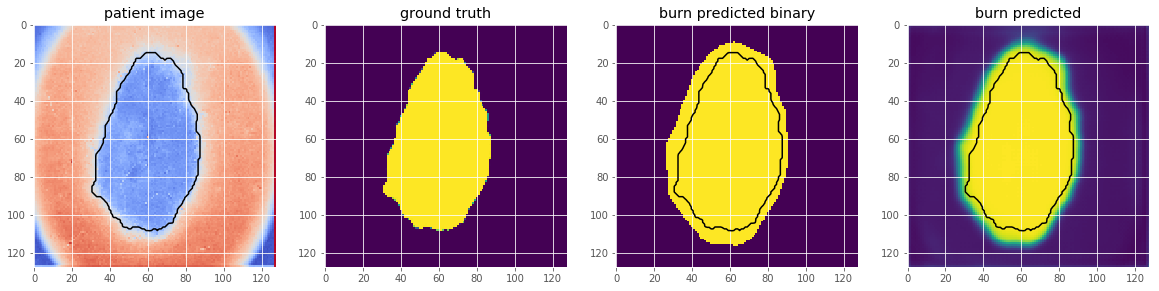

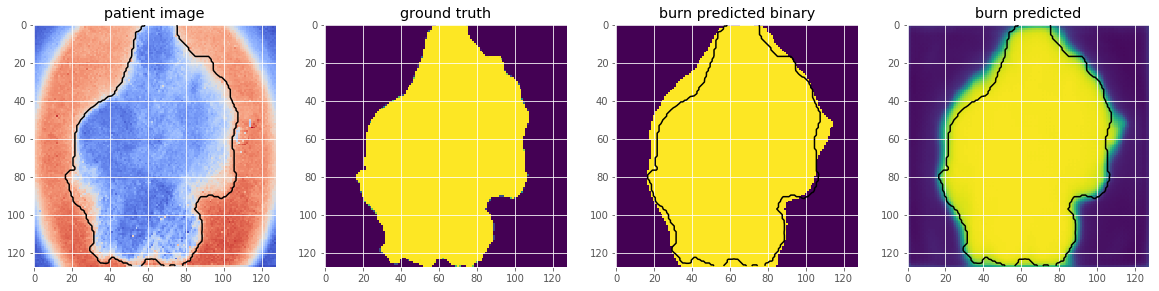

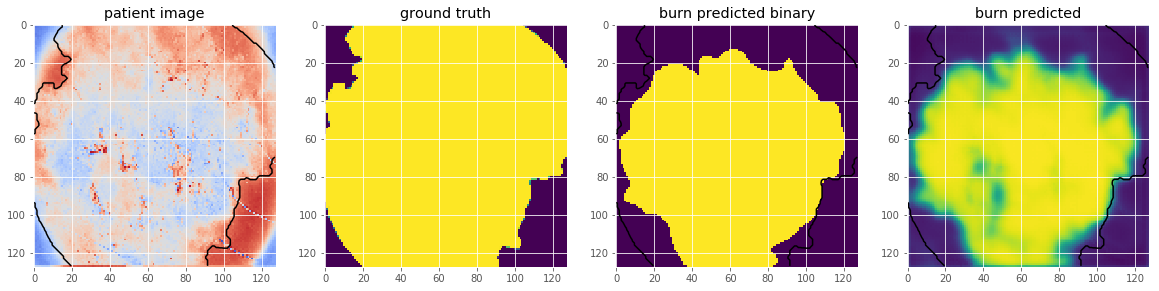

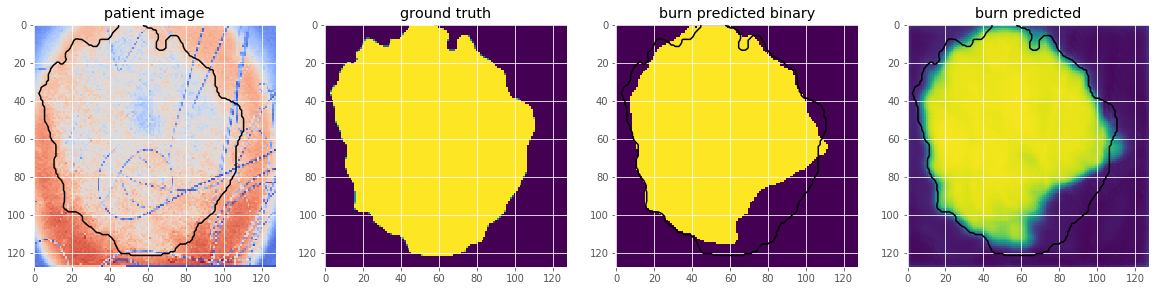

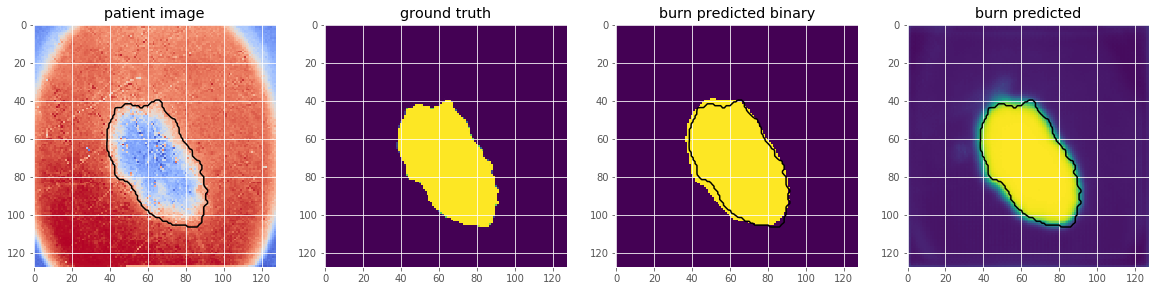

In [39]:
for u in range(20,40):
    plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=u)

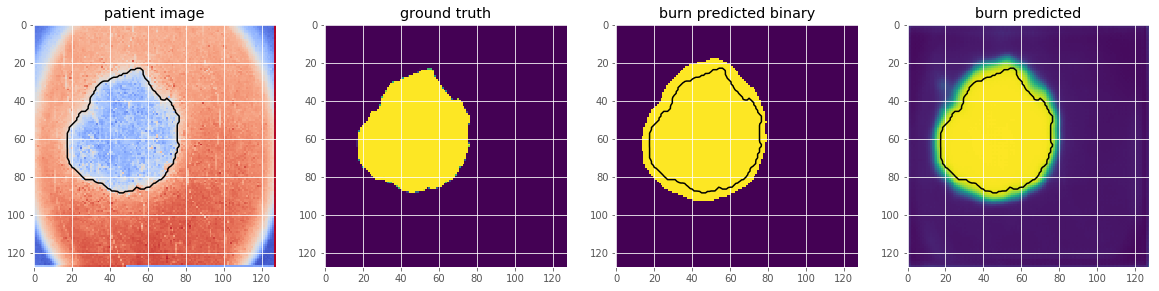

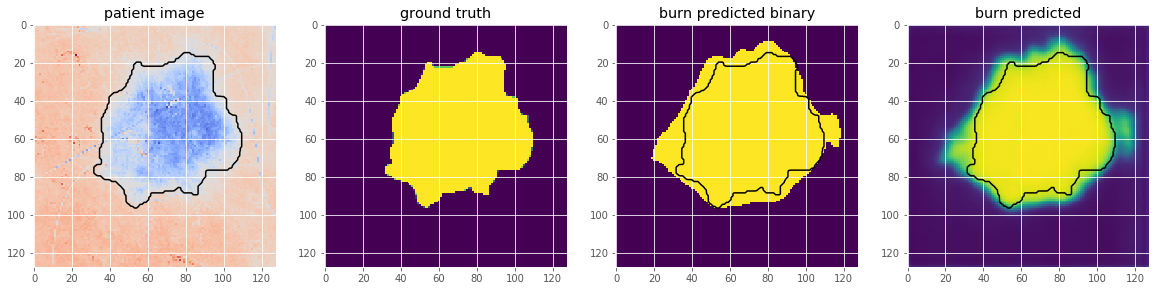

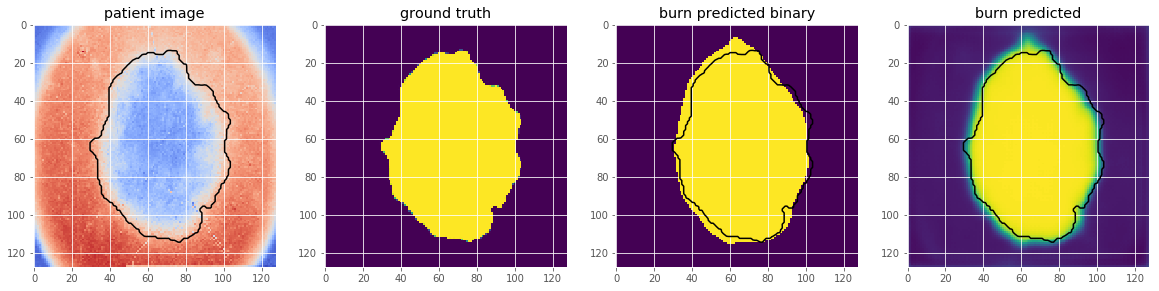

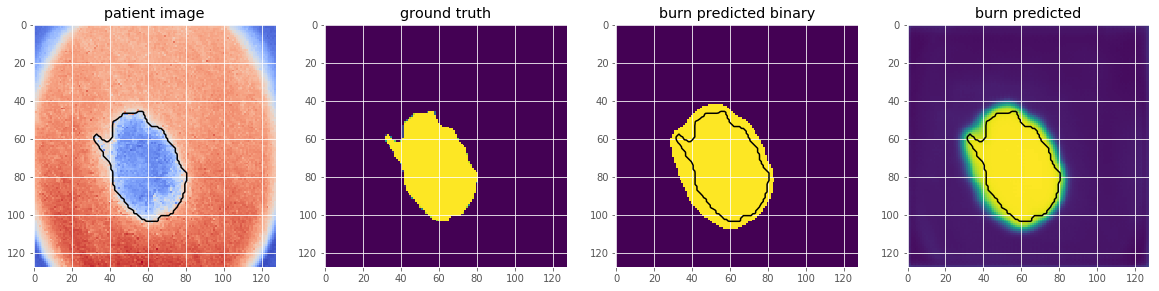

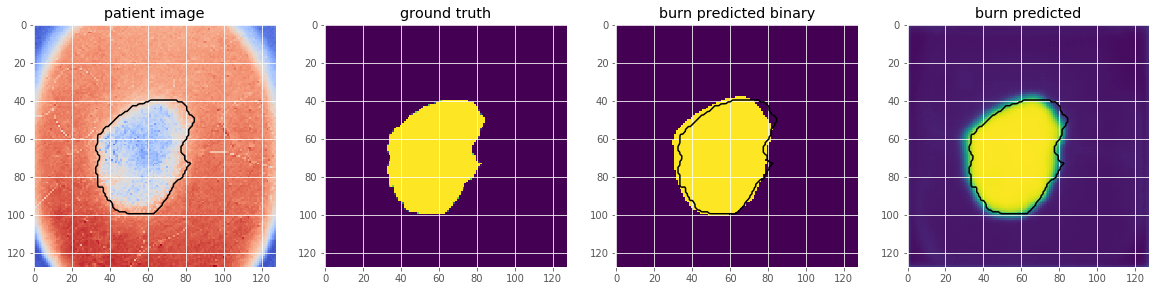

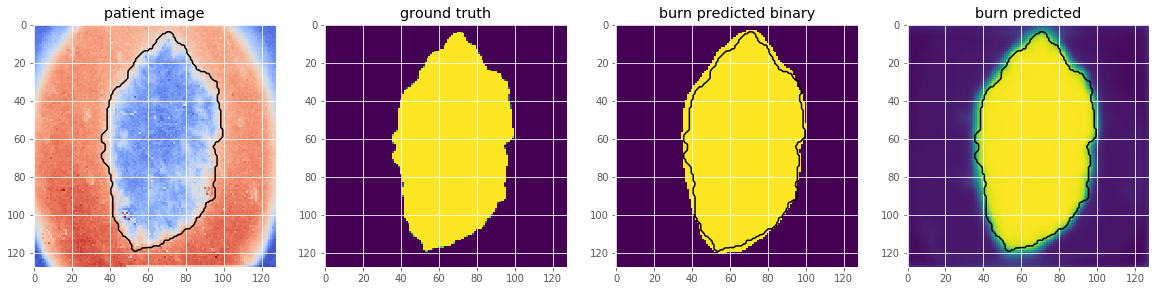

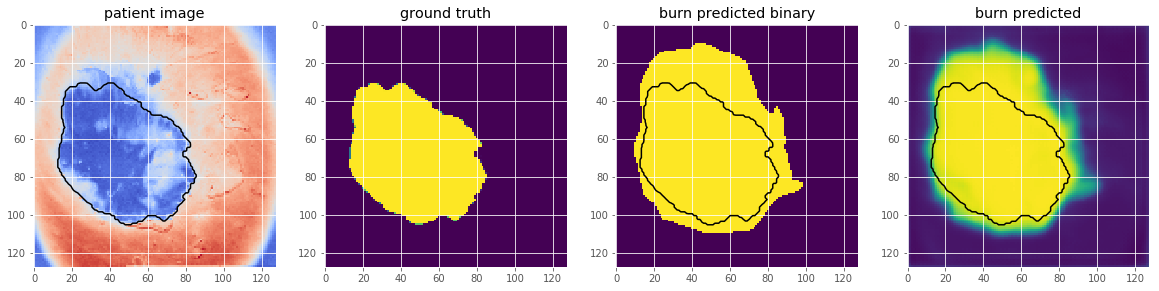

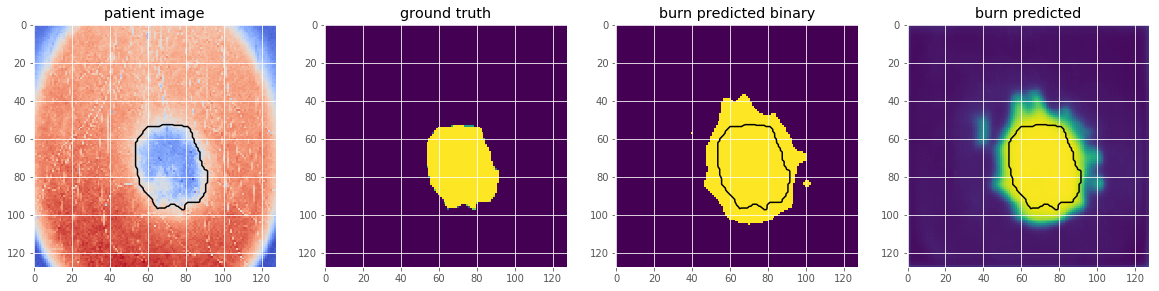

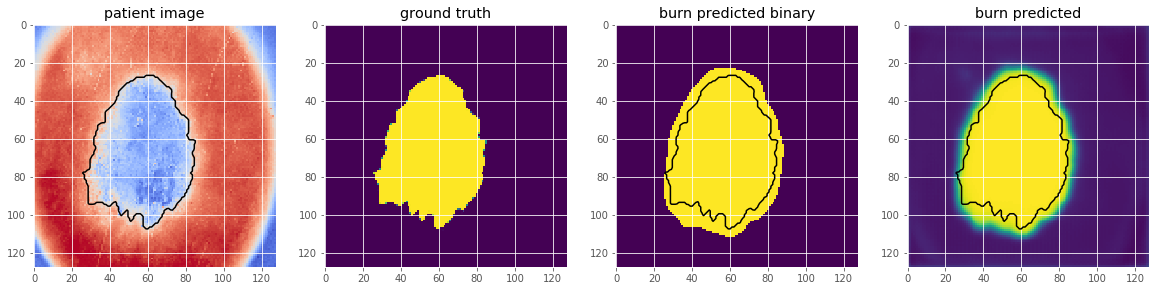

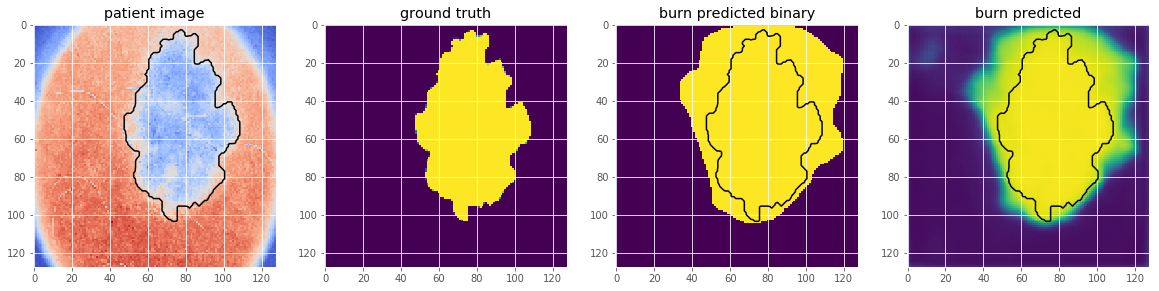

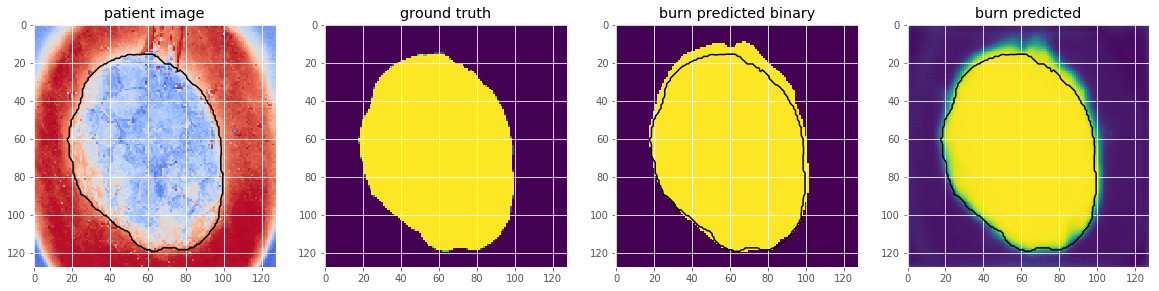

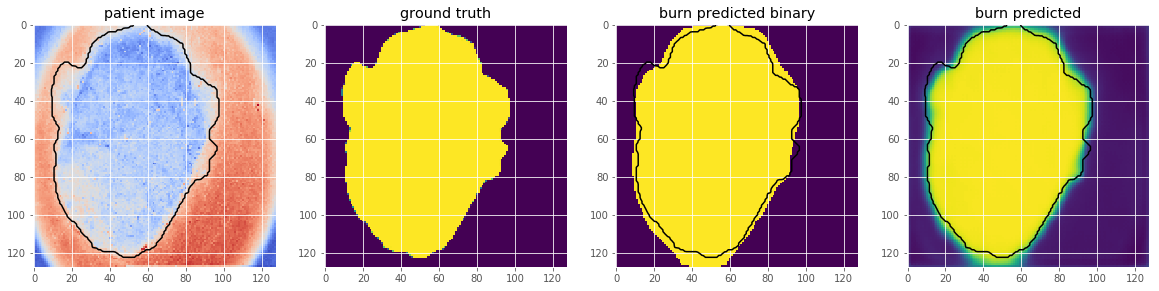

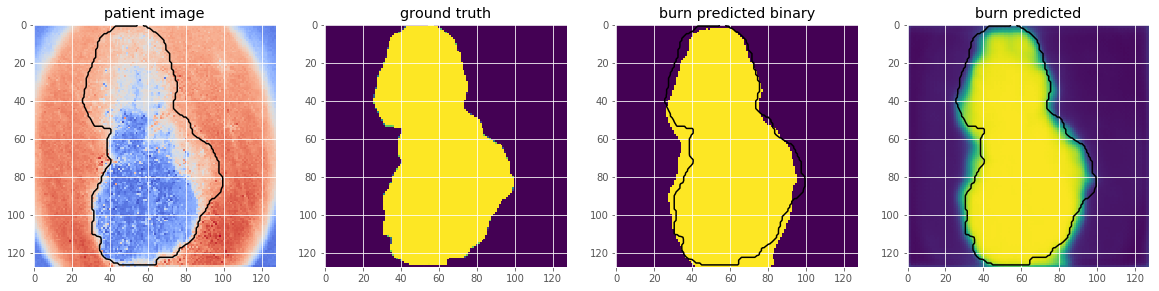

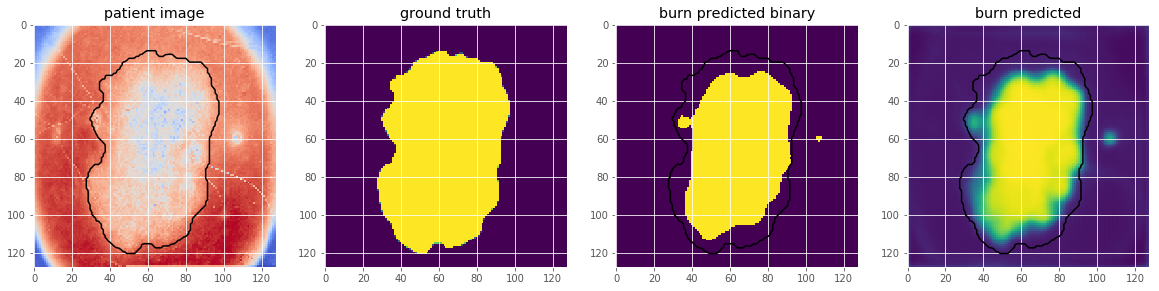

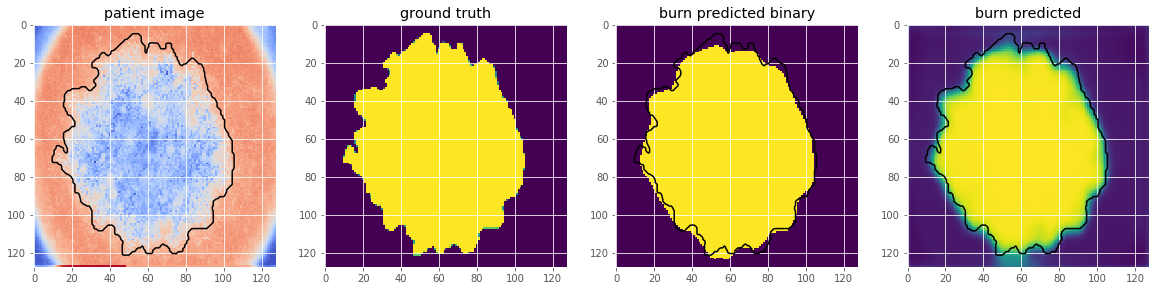

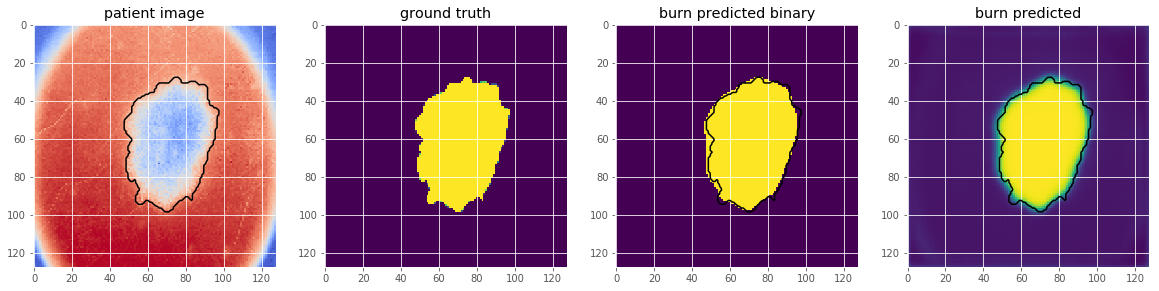

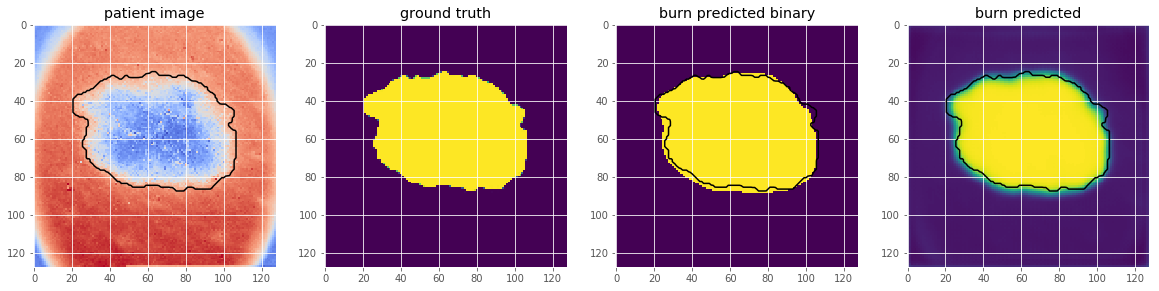

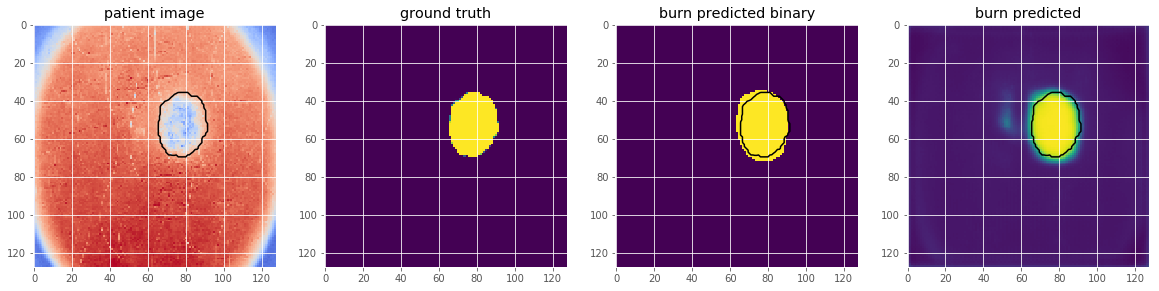

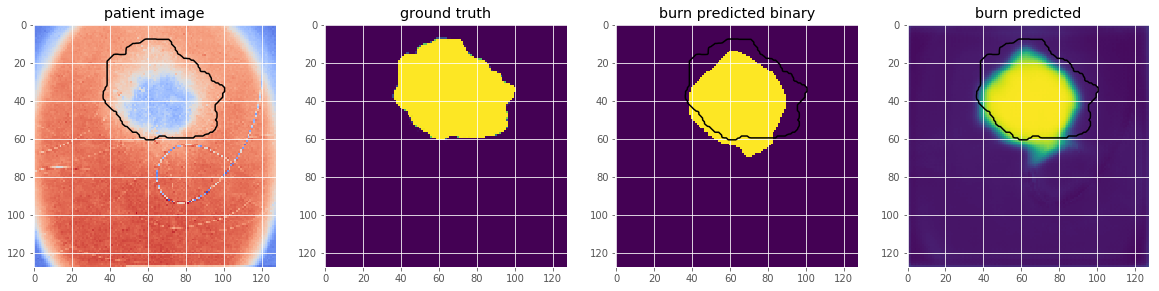

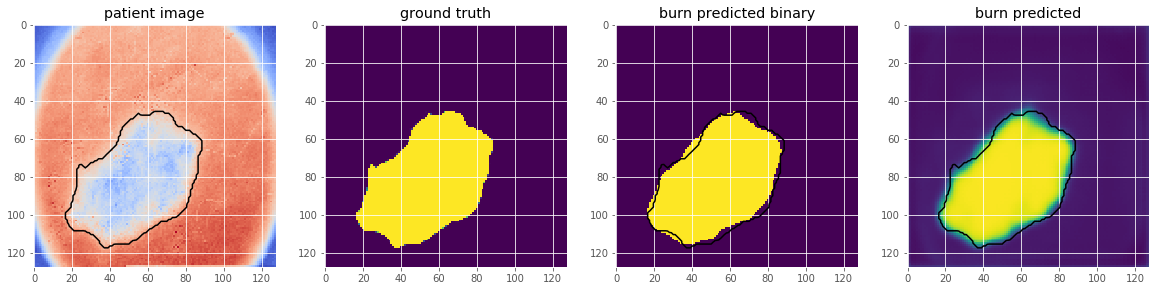

In [38]:
for u in range(40,60):
    plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=u)